In [1]:
%matplotlib inline
# %matplotlib widget # 跟圖互動，可以用點選圖片中的某位置觸發程式
%env KERAS_BACKEND = tensorflow
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from random import shuffle
# from matplotlib.widgets import Cursor, Button
from ipywidgets import interact, IntSlider, Button
from ipywidgets import interact_manual
import IPython.display as ipd
# import networkx as nx # draw graph vertex & edge
# import pydub # audio
# from numpy.fft import fft, ifft, irfft, rfft # fourier transform
# import sympy as sym
# from sympy import S,N
# import locale # 資料處理 轉換數字格式

# from sklearn.linear_model import LinearRegression
# from keras.utils import np_utils #one hot encoding
# from keras.models import Sequential #神經網路的框架keras.models
from keras.layers import Dense, Activation, Embedding
from keras.layers import advanced_activations
# from keras.layers import LSTM
from keras.layers import Flatten # 將資料展平
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D
from keras.layers import Conv1D, MaxPool1D, MaxPooling1D
from keras.optimizers import SGD, Adadelta, Adam
from keras.models import model_from_json
# from keras.callbacks import History
# from keras.datasets import mnist # mnist內 包含手寫測試資料
# from keras.datasets import imdb # imdb內 包含電影評論資料
# from keras.preprocessing import sequence # 用來同整不同長度的電影評論，多的擷掉，少的補 0
# from keras.preprocessing.text import Tokenizer # 轉換文字成數字
# from sklearn.model_selection import train_test_split

# for Functional API
from keras.models import Model
from keras.layers import Input
from keras.layers import concatenate, add
from keras.layers import Reshape
# for Functional API transfer learning
from keras.layers.core import Lambda
from keras import backend as K
from keras import metrics

# from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout

import matplotlib.image as mpimg # import image file
from PIL import Image, ImageEnhance, ImageFont, ImageDraw, ImageFilter # image processing

env: KERAS_BACKEND=tensorflow


Using TensorFlow backend.


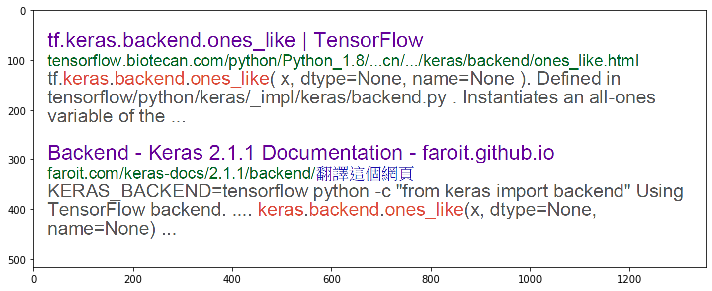

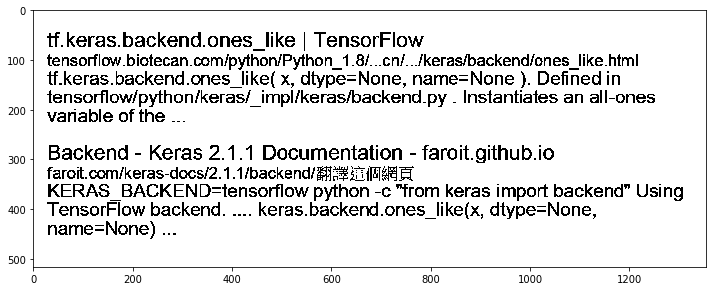

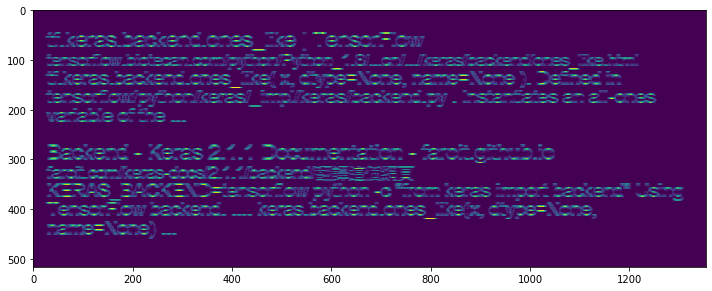

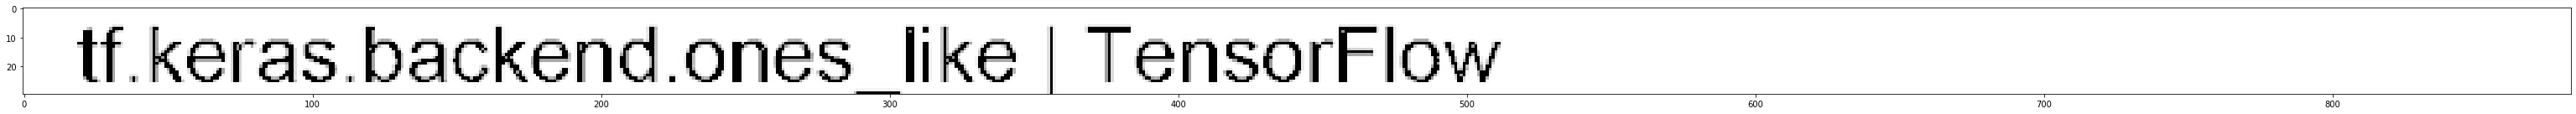

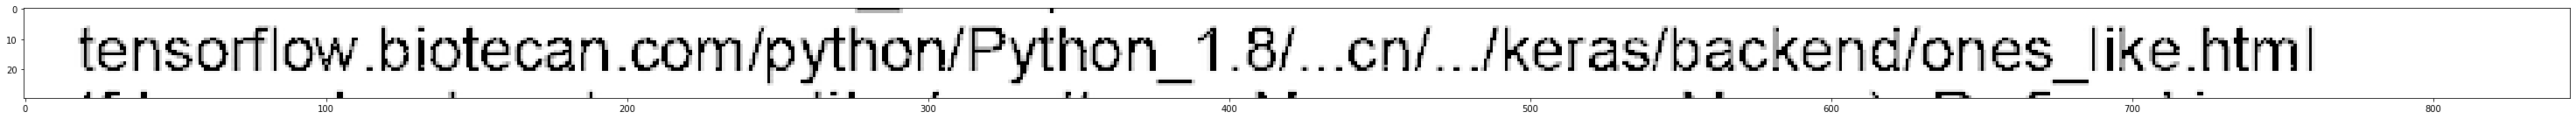

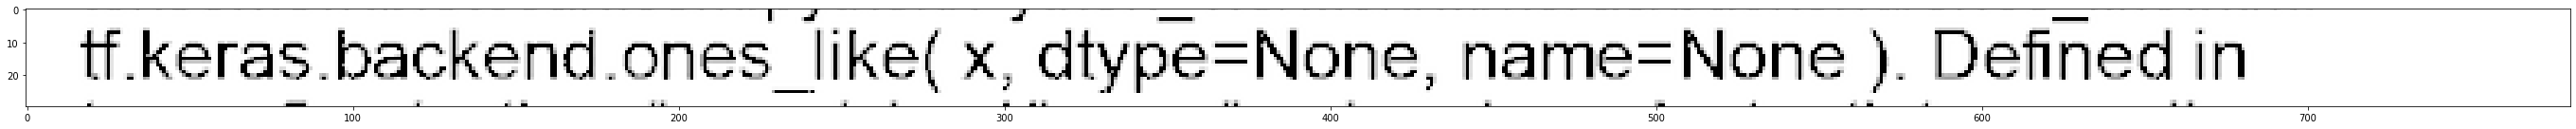

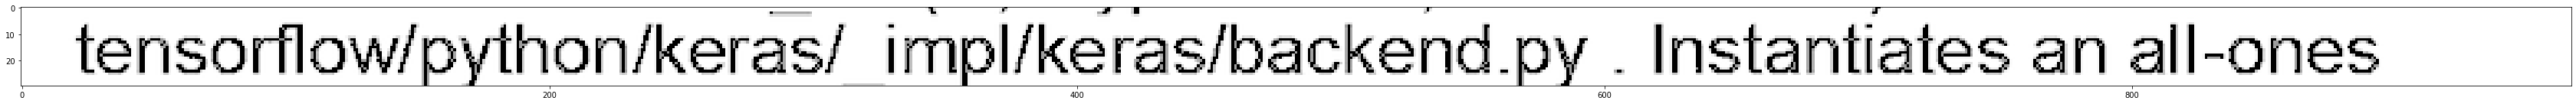

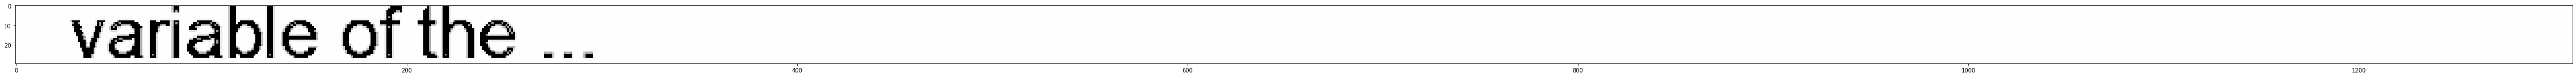

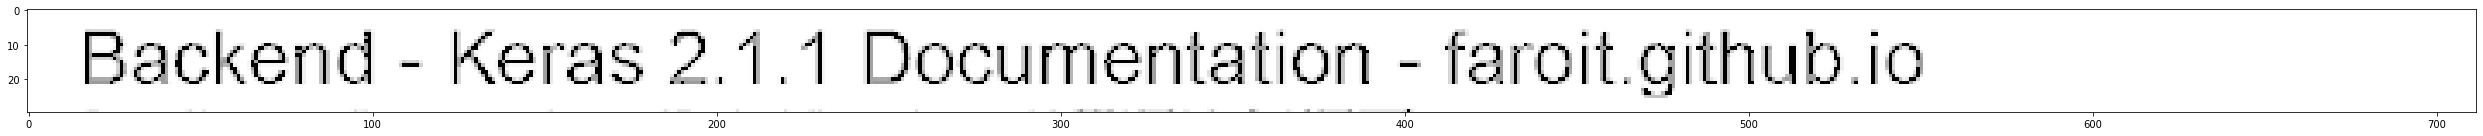

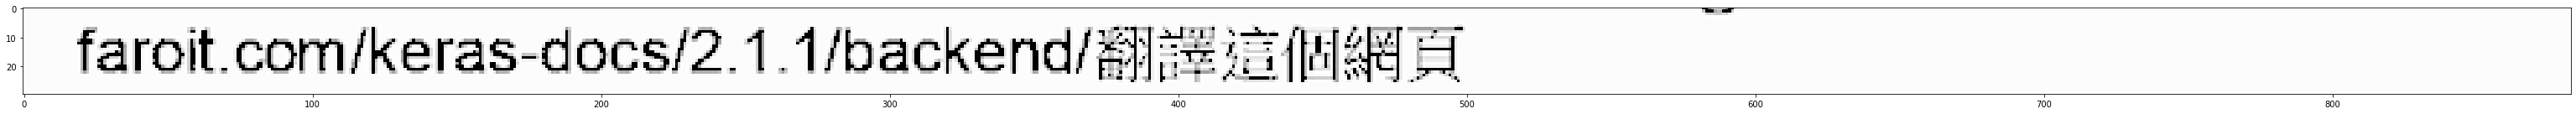

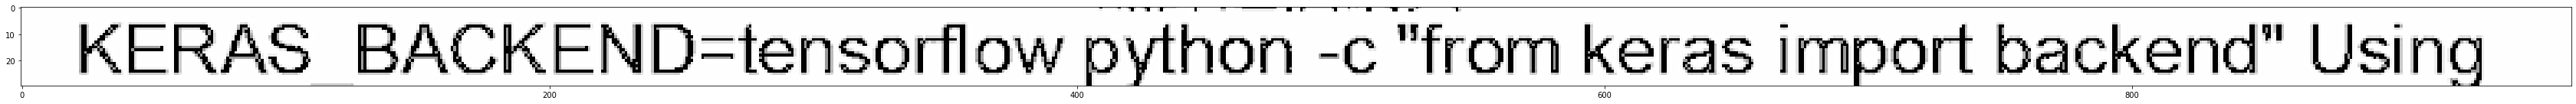

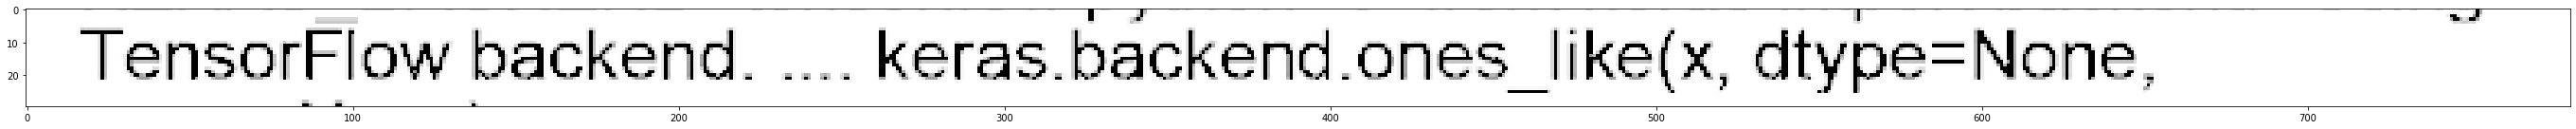

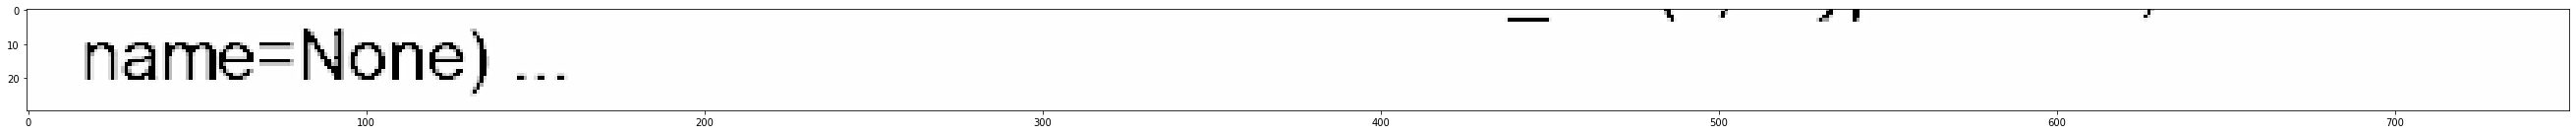

In [15]:
split_line_input = Input(shape = (None, None, 1), name = 'split_line_input')
# z = Lambda(lambda v: K.ones_like(v) - v, name = 'split_line_input_color_recerse')(split_line_input)
filter_size = 8
layer = Conv2D(3, (filter_size, filter_size), padding = 'same', trainable = False, name = 'split_line_c1')
z = layer(split_line_input)

### setting weights
w = layer.get_weights()
w[0][:, :, 0, 0] = 0
w[0][0, :, 0, 0] = filter_size
w[0][:, :, 0, 1] = 0
w[0][-1:, :, 0, 1] = filter_size
w[0][:, :, 0, 2] = 1
w[1] = np.zeros_like(w[1])
layer.set_weights(w)

split_line_Lambda = Lambda(lambda v: 
                           K.concatenate([v[:, :, :, 0:1] - v[:, :, :, 2:3], 
                                          v[:, :, :, 1:2] - v[:, :, :, 2:3]], 
                                         axis = -1), 
                           name = 'split_line_Lambda')(z)
z = Activation('relu', name = 'split_line_relu')(split_line_Lambda)
split_line_model = Model(split_line_input, z, name = 'split_line_model')
# print(split_line_model.summary())

def crop_array_image(img, *rects):
    y = img.shape[0]
    x = img.shape[1]
    startx, starty, cropx, cropy = rects
    endx = min(startx + cropx, x)
    endy = min(starty + cropy, y)
    return img[starty:endy, startx:endx]

def zooming_rectangle(*rects, h_rate = 1., w_rate = 1.):
    startx, starty, cropx, cropy = rects
    new_startx = int((1. - w_rate) * cropx / 2 + startx)
    new_starty = int((1. - h_rate) * cropy / 2 + starty)
    new_cropx = int(cropx * w_rate)
    new_cropy = int(cropy * h_rate)
    return (new_startx, new_starty, new_cropx, new_cropy)

def increase_contrast_function(x, s = 0.2, e = 0.8):
    max_x = np.max(x.reshape(-1))
    min_x = np.min(x.reshape(-1))
    assert max_x - min_x != 0, "In increase_contrast_function: There are no variations in the input data."
    if not (max_x <= 1. and min_x >= 0):
        x = (x - min_x) / (max_x - min_x)
    def normalized_increase_contrast_function(x):
        if x < s:
            return 0.
        if x > e:
            return 1.
        x -= s
        x *= e - s
        return -2 * x**3 + 3 * x**2
    x = np.vectorize(normalized_increase_contrast_function)(x)
    if not (max_x <= 1. and min_x >= 0):
        return x * (max_x - min_x) + min_x
    else:
        return x

image_index = 4
img_png_0 = mpimg.imread("image_test/line_test_{}.png".format(image_index))
height, width , _ = img_png_0.shape
assert height > filter_size * 2 and width > filter_size * 4, "The image is too small, please capture a large one!"
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_png_0, interpolation='nearest')
plt.tight_layout()

####### increase contrast #######
img_png = increase_contrast_function(img_png_0)
img_png = increase_contrast_function(img_png)
# img_png = np.average(img_png, axis = 2) # transform to only 1 chennel
img_png = np.min(img_png, axis = 2) # transform to only 1 chennel
img_png = 1 - img_png
# img_png = img_png[:, 450:500]
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_png, interpolation='nearest', cmap='Greys')
plt.tight_layout()

predicts = split_line_model.predict(img_png.reshape(1, *(img_png.shape), 1))
A = np.zeros(predicts[0].shape[0:2])
A[0:-3, :] += predicts[0][3:, :, 0]
A[3:, :] += predicts[0][0:-3, :, 1]

# A = increase_contrast_function(A, s = 0.1, e = 0.99)
# A = increase_contrast_function(A, s = 0.01, e = 0.5)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(A, interpolation='nearest')
plt.tight_layout()

# B = np.average(A, axis = 1)
# B = np.max(A, axis = 1)
B = 0.5 * np.max(A, axis = 1) + 0.5 * np.average(A, axis = 1)
B = np.array([1. 
              if B[i] - np.min(B.reshape(-1)) > (np.max(B.reshape(-1)) - np.min(B.reshape(-1))) * 0.1 
              else 0. 
              for i in range(len(B))])
go_up_list = [0 for i in range(1) if B[0] > 0.5] + [i for i in range(len(B)-1) if B[i + 1] - B[i] > 0.5]
if B[-1] > 0.5:
    go_up_list.pop(-1)
go_down_list = [i for i in range(len(B)-1) if B[i] - B[i + 1] > 0.5]
assert len(go_up_list) == len(go_down_list), "The lenghts of go_up_list and go_down_list are not equal."
varlist = go_up_list + go_down_list
varlist.sort()

rectlist = [[0, varlist[2 * i], width, varlist[2 * i + 1] - varlist[2 * i]] 
            for i in range(len(varlist) // 2) 
           if varlist[2 * i + 1] - varlist[2 * i] >= filter_size]
for i in range(len(rectlist)):
    rectlist[i] = zooming_rectangle(*rectlist[i], h_rate = 1.5, w_rate = 1.)

line_list = []
line_list_normalize = []
line_list_normalize_ratio = [] # line_list_normalize_ratio[i] * line_list_normalize[i].shape[0] == line_list[i].shape[0]
new_line_hh = 30
assert len(rectlist) != 0, "There are no lines that is detected."
for rect in rectlist:
    C = crop_array_image(img_png, *rect)
    line_list.append(C)

    C_PIL = Image.fromarray(C)
    ww, hh = C_PIL.size
    new_line_ww = new_line_hh * ww // hh
    C_PIL = C_PIL.resize((new_line_ww, new_line_hh), Image.ANTIALIAS) # Not maintain the ratio
    # C.thumbnail((1000, 1000), Image.ANTIALIAS) # maintain the ratio
    C = np.array(C_PIL)
    C = increase_contrast_function(C, s = 0.1, e = 0.8)
    C -= np.min(C.reshape(-1))
    C = C / np.max(C.reshape(-1))
    line_list_normalize.append(C)
    line_list_normalize_ratio.append(hh / new_line_hh)
    # mpimg.imsave("image_test/line_test_line.png", C)

    fig, ax = plt.subplots(figsize=(100, 2))
    ax.imshow(C, interpolation='nearest', cmap='Greys')
    plt.tight_layout()

line_list_normalize_segements = []
segements_hh = new_line_hh
segements_ww = 120
assert segements_ww % 6 == 0, "YOLO model requires that segements_ww % 6 == 0"
segements_overlapping_ww = 20
for i in range(len(line_list_normalize)):
    line_list_normalize_segements.append([])
    new_line_ww = line_list_normalize[i].shape[1]
    number_of_segements = (new_line_ww - segements_overlapping_ww) // (segements_ww - segements_overlapping_ww)
    if (new_line_ww - segements_overlapping_ww) % (segements_ww - segements_overlapping_ww) != 0:
        number_of_segements += 1
    for j in range(number_of_segements):
        D = np.zeros((segements_hh, segements_ww))
        rect = [(segements_ww - segements_overlapping_ww) * j, 
                0, segements_ww, segements_hh]
        DD = crop_array_image(line_list_normalize[i], *rect)
        D[:, 0:DD.shape[1]] = DD
        line_list_normalize_segements[i].append(D)

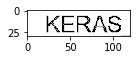

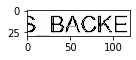

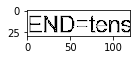

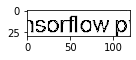

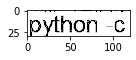

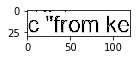

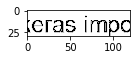

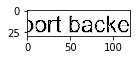

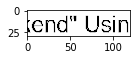

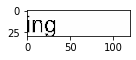

In [25]:
i = 7
for j in range(len(line_list_normalize_segements[i])):
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.imshow(line_list_normalize_segements[i][j], interpolation='nearest', cmap='Greys')
    plt.tight_layout()

In [ ]:
# ################製作測試資料用##################

# # %matplotlib inline
# %matplotlib widget
# from matplotlib.widgets import Cursor, Button
# from IPython.display import clear_output

# i = 1
# j = 3
# C = line_list_normalize_segements[i][j]
# fig, ax = plt.subplots(figsize=(20, 1))
# ax.imshow(C, cmap='Greys')

# xs = []

# press_count = 0
# cilck_count = 0
# cursor = Cursor(ax,
#                 horizOn = False, # Controls the visibility of the horizontal line
#                 vertOn = True, # Controls the visibility of the vertical line
#                 color = 'green',
#                 linewidth = 2.0
#                )
# def onclick(event):
#     # clear_output()
#     global press_count, cilck_count
#     if press_count % 2 == 0:
#         global xs
#         x1, _1 = event.xdata, event.ydata
#         xs.append(x1)
#         if cilck_count % 4 < 2:
#             plt.vlines(x1, 0, C.shape[0], colors = "r")
#         else:
#             plt.vlines(x1, 0, C.shape[0], colors = "b")
#         cilck_count += 1

# def press(event):
#     # clear_output()
#     global press_count
#     if event.key == 'e':
#         press_count +=1
# fig.canvas.mpl_connect('button_press_event', onclick);
# fig.canvas.mpl_connect('key_press_event', press);
# # plt.tight_layout()
# # plt.show()

In [29]:
# np.array(xs).reshape((-1, 2))

array([[ 11.52124724,  27.13477856],
       [ 23.01088231,  38.32821123],
       [ 34.79344302,  44.21949158],
       [ 41.27385141,  54.23466818],
       [ 50.11077194,  66.01722889],
       [ 62.48246068,  79.5671737 ],
       [ 87.8149662 , 100.18665494],
       [104.31055119, 116.68223993]])

In [4]:
# import ctypes

# def GetTextDimensions(text, points, font):
#     class SIZE(ctypes.Structure):
#         _fields_ = [("cx", ctypes.c_long), ("cy", ctypes.c_long)]

#     hdc = ctypes.windll.user32.GetDC(0)
#     hfont = ctypes.windll.gdi32.CreateFontA(points, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, font)
#     hfont_old = ctypes.windll.gdi32.SelectObject(hdc, hfont)

#     size = SIZE(0, 0)
#     ctypes.windll.gdi32.GetTextExtentPoint32A(hdc, text, len(text), ctypes.byref(size))

#     ctypes.windll.gdi32.SelectObject(hdc, hfont_old)
#     ctypes.windll.gdi32.DeleteObject(hfont)

#     return (size.cx, size.cy)

# print(GetTextDimensions("Hello world", 12, "Times New Roman"))
# print(GetTextDimensions("Hello world", 12, "Arial"))

(55, 12)
(55, 12)


### See [用-python-在圖像上寫字](https://medium.com/@sean22492249/%E7%94%A8-python-%E5%9C%A8%E5%9C%96%E5%83%8F%E4%B8%8A%E5%AF%AB%E5%AD%97-d62a431ea727)
### [How to get the font pixel height using PIL' ImageFont?](https://stackoverflow.com/questions/43060479/how-to-get-the-font-pixel-height-using-pil-imagefont)

Instructions for updating:
Colocations handled automatically by placer.


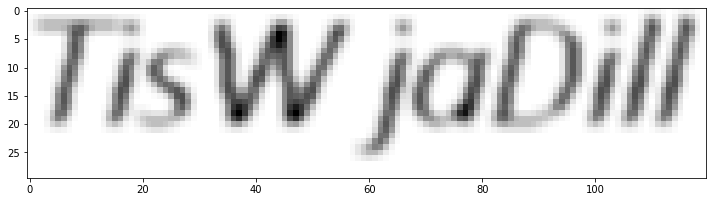

In [3]:
segements_hh = 30
segements_ww = 120
frame = Image.fromarray(np.zeros((segements_hh, segements_ww)))
draw = ImageDraw.Draw(frame)
font_size = 28
font = ImageFont.truetype("times.ttf", font_size)
# # font = ImageFont.truetype("fonts/impact.ttf", font_size) # font.font.getsize會跑掉 而且字體太特殊
font = ImageFont.truetype("fonts/calibri.ttf", font_size)
font = ImageFont.truetype("fonts/calibrili.ttf", font_size)

left = -7 + 2 + 5
top = -2 + 2
string = "TisW jaDill"
draw.text((left, top), string, 1., font = font)

######### setting bounding boxes #########
# idx = 3
# size = np.array([font.font.getsize(string[0:idx]), font.font.getsize(string[0:idx + 1])])[:, 0, 0] - 1
# draw.rectangle((left + size[0], 0, left + size[1] , 30 - 1), outline = 0.2)

######### GaussianBlur #########
# frame = frame.convert("RGB")
# frame = frame.filter(ImageFilter.GaussianBlur(radius = 2))
# frame = frame.convert("L")

GaussianBlur_input = Input(shape = (None, None, 1), name = 'GaussianBlur_input')
filter_size = 4
layer = Conv2D(1, (filter_size, filter_size), padding = 'same', trainable = False, name = 'GaussianBlur_c1')
GaussianBlur_output = layer(GaussianBlur_input)

### setting weights
w = layer.get_weights()
kernel = np.array([1., 2., 2., 1.]).reshape(1, -1)
kernel = (kernel.T).dot(kernel)
kernel = kernel / np.sum(kernel.reshape(-1))
w[0][:, :, 0, 0] = kernel
w[1] = np.zeros_like(w[1])
layer.set_weights(w)

GaussianBlur_model = Model(GaussianBlur_input, GaussianBlur_output, name = 'GaussianBlur_model')

######### show #########
array_frame = np.array(frame)
array_frame = GaussianBlur_model.predict(array_frame.reshape(1, *(array_frame.shape), 1))[0, :, :, 0]
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(array_frame, interpolation='nearest', cmap='Greys')
plt.tight_layout()

# YOLO model without anchor box

<pre>
output_dim: 1 , (segements_ww // 6) , (1 + 2 + total_classes_number)

1 , (segements_ww // 6):  
	slice (segements_ww) into (segements_ww // 6) parts,  
    and slice segements_hh into 1 parts.

(1 + 2 + total_classes_number):  
	1: pc  
	2: the width informations of bounding box (default height coordinates: 0, segements_hh)  
    	(relative_coordinate_of_centor_of_box, relative_width_of_box)  
	total_classes_number: = len(labels), one hot encoding
</pre>

In [43]:
segements_hh = 30
segements_ww = 120

def IOU():
    return 1
def non_maximal_suppression():
    return 1
labels = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", 
          "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", 
          "A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", 
          "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", 
          "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", 
          " ", "(", ")", ",", ".", "[", "]", "'", "\"", "nothing"]
total_classes_number = len(labels)

layer_id = 0
YOLO_input = Input(shape = (segements_hh, segements_ww, 1), name = 'YOLO_input')
z = YOLO_input

######### main_body #########
layer_id += 1
z = Conv2D(16, 8, padding = 'same', name = 'YOLO_c{}'.format(layer_id))(z)
z = advanced_activations.LeakyReLU(alpha=0.1, name = 'YOLO_LeakyReLU_{}'.format(layer_id))(z)
layer_id += 1
z = Conv2D(32, 8, name = 'YOLO_c{}'.format(layer_id))(z)
z = advanced_activations.LeakyReLU(alpha=0.1, name = 'YOLO_LeakyReLU_{}'.format(layer_id))(z)
layer_id += 1
z = Conv2D(64, 5, name = 'YOLO_c{}'.format(layer_id))(z)
z = advanced_activations.LeakyReLU(alpha=0.1, name = 'YOLO_LeakyReLU_{}'.format(layer_id))(z)
layer_id += 1
z = Conv2D(128, 3, name = 'YOLO_c{}'.format(layer_id))(z)
z = advanced_activations.LeakyReLU(alpha=0.1, name = 'YOLO_LeakyReLU_{}'.format(layer_id))(z)
main_body = z

######### pc #########
pc_layer_start = layer_id + 1
z = main_body
layer_id += 1
z = Conv2D(32, 3, name = 'YOLO_c{}'.format(layer_id))(z)
z = advanced_activations.LeakyReLU(alpha=0.1, name = 'YOLO_LeakyReLU_{}'.format(layer_id))(z)
z = MaxPool2D(pool_size = (2, 2), name = 'YOLO_p{}'.format(layer_id))(z)
layer_id += 1
z = Conv2D(64, (3, 3), name = 'YOLO_c{}'.format(layer_id))(z)
z = advanced_activations.LeakyReLU(alpha=0.1, name = 'YOLO_LeakyReLU_{}'.format(layer_id))(z)
layer = MaxPool2D(pool_size = (2, 2), name = 'YOLO_p{}'.format(layer_id))
z = layer(z)

layer_id += 1
assert layer.output_shape[-2] >= segements_ww // 6, "YOLO input shape is too small."
filter_size = [layer.output_shape[-3], layer.output_shape[-2] - (segements_ww // 6) + 1]
z = Conv2D(1, filter_size, name = 'YOLO_c{}'.format(layer_id), activation = 'sigmoid')(z)
pc_output = z
pc_layer_end = layer_id

######### boxes_position_informations #########
boxes_position_informations_layer_start = layer_id + 1
z = main_body
layer_id += 1
z = Conv2D(32, 3, name = 'YOLO_c{}'.format(layer_id))(z)
z = advanced_activations.LeakyReLU(alpha=0.1, name = 'YOLO_LeakyReLU_{}'.format(layer_id))(z)
z = MaxPool2D(pool_size = (2, 2), name = 'YOLO_p{}'.format(layer_id))(z)
layer_id += 1
z = Conv2D(64, (3, 3), name = 'YOLO_c{}'.format(layer_id))(z)
z = advanced_activations.LeakyReLU(alpha=0.1, name = 'YOLO_LeakyReLU_{}'.format(layer_id))(z)
layer = MaxPool2D(pool_size = (2, 2), name = 'YOLO_p{}'.format(layer_id))
z = layer(z)

layer_id += 1
assert layer.output_shape[-2] >= segements_ww // 6, "YOLO input shape is too small."
filter_size = [layer.output_shape[-3], layer.output_shape[-2] - (segements_ww // 6) + 1]
z = Conv2D(2, filter_size, name = 'YOLO_c{}'.format(layer_id))(z)
layer_id += 1
z = Lambda(lambda v: K.concatenate([K.sigmoid(v[:, :, :, 0:1]), K.exp(v[:, :, :, 1:])], axis = 3), 
           name = 'YOLO_L{}'.format(layer_id))(z)
boxes_position_informations_output = z
boxes_position_informations_layer_end = layer_id

######### classes_classification #########
classes_classification_layer_start = layer_id + 1
z = main_body
layer_id += 1
z = Conv2D(32, 3, name = 'YOLO_c{}'.format(layer_id))(z)
z = advanced_activations.LeakyReLU(alpha=0.1, name = 'YOLO_LeakyReLU_{}'.format(layer_id))(z)
z = MaxPool2D(pool_size = (2, 2), name = 'YOLO_p{}'.format(layer_id))(z)
layer_id += 1
z = Conv2D(64, 3, name = 'YOLO_c{}'.format(layer_id))(z)
z = advanced_activations.LeakyReLU(alpha=0.1, name = 'YOLO_LeakyReLU_{}'.format(layer_id))(z)
layer = MaxPool2D(pool_size = (2, 2), name = 'YOLO_p{}'.format(layer_id))
z = layer(z)

layer_id += 1
assert layer.output_shape[-2] >= segements_ww // 6, "YOLO input shape is too small."
filter_size = [layer.output_shape[-3], layer.output_shape[-2] - (segements_ww // 6) + 1]
z = Conv2D(total_classes_number, filter_size, name = 'YOLO_c{}'.format(layer_id), activation = 'relu')(z)
layer_id += 1
z = Conv2D(total_classes_number, 1, name = 'YOLO_c{}'.format(layer_id), activation = 'softmax')(z)
classes_classification_output = z
classes_classification_layer_end = layer_id


######### concatenate & YOLO_output #########
layer_id += 1
z = concatenate([pc_output, boxes_position_informations_output, classes_classification_output], 
                axis = 3, name = 'YOLO_concatenate{}'.format(layer_id))
YOLO_output = z
YOLO_model = Model(YOLO_input, YOLO_output, name = 'YOLO_model')
print('pc_layer: \t\t\t\t{}\t~\t{}'.format(pc_layer_start, 
                                    pc_layer_end))
print('boxes_position_informations_layer: \t{}\t~\t{}'.format(boxes_position_informations_layer_start, 
                                    boxes_position_informations_layer_end))
print('classes_classification_layer: \t\t{}\t~\t{}'.format(classes_classification_layer_start, 
                                    classes_classification_layer_end))
print(YOLO_model.summary())

pc_layer: 				5	~	7
boxes_position_informations_layer: 	8	~	11
classes_classification_layer: 		12	~	15
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
YOLO_input (InputLayer)         (None, 30, 120, 1)   0                                            
__________________________________________________________________________________________________
YOLO_c1 (Conv2D)                (None, 30, 120, 16)  1040        YOLO_input[0][0]                 
__________________________________________________________________________________________________
YOLO_LeakyReLU_1 (LeakyReLU)    (None, 30, 120, 16)  0           YOLO_c1[0][0]                    
__________________________________________________________________________________________________
YOLO_c2 (Conv2D)                (None, 23, 113, 32)  32800       YOLO_LeakyReLU_1[0][0]           
______